# Scrape BeerAdvocate for beer ratings
This notebook scrapes BeerAdvocate for ratings of beer to subsequently perform linear regression on the ratings in terms of other available information on the beer. We start with the style page since we can use this to obtain a list of all beers of that style easily from there.

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import random
import os
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from fake_useragent import UserAgent
from collections import defaultdict

%matplotlib inline

## Useful constants and functions

In [19]:
base_url = "https://www.beeradvocate.com"
start_url = base_url+"/beer/style/"

ua = UserAgent()

def download_parse_ba(style_file, url):
    """
    sytle_file: file to be written (including subdirectory)
    url: url to read from
    Reads a url from BeerAdvocate.com and dumps
    its main content into a local HTML file
    """
    
    user_agent = {'User-agent': ua.random}
    
    r = requests.get(url, headers = user_agent)
    soup = BeautifulSoup(r.text, "lxml")
    main_content = soup.find(id='ba-content')
    
    with open(style_file, 'w') as file:
        file.write(str(main_content))
    
    time.sleep(random.uniform(2, 4))
    
    return

def find_style_num(style_file):
    """
    style_file: html file in style list
    Returns the total number of beers in the style category
    """
    with open(style_file, 'r') as file:
        page = file.read()
    
    soup = BeautifulSoup(page,"lxml")
        
    # Find number of beers for the style

    beer_num_tag = soup.find('table').find('span').find('b').text
    
    # Find 'word' directly to the left of a parentheses
    criteria = re.compile('\w+\)')

    found = re.search(criteria, beer_num_tag)
    
    return int(found.group(0).split(')')[0])

def parse_beers_links(style_file, beer_dict):
    """
    style_file: html file in style list
    beer_links: reference to dictionary of beers to update
    Updates dictionary with each beer, its associated data,
    and a link to its review page
    Returns True if a beer on the page had less than 10 ratings
    Returns False otherwise
    """
    
    with open(style_file, 'r') as file:
        soup = BeautifulSoup(file.read(), "lxml")
        
    beer_rows = soup.find("table").findAll("tr")
    
    # Flag to stop reading entries when number of ratings is less than 10
    stop_flag = False
    
    for beer_row in beer_rows[3:len(beer_rows)-1]:
        table_entries = beer_row.findAll("td")
        namelink = table_entries[0].find("a")
    
        beer_link = namelink['href']
        beer_name = namelink.text
        
        beer_name = re.sub("\/", "", beer_name)
        beer_name = re.sub("\.", "", beer_name)
        
        brewery = table_entries[1].find("a").text
        brewery = re.sub("\/", "", brewery)
        brewery = re.sub("\.", "", brewery)
        
        abv = table_entries[2].find("span").text
        
        score = table_entries[3].find("b").text
        
        ratings = int(re.sub(",", "", table_entries[4].find("b").text))
        
        if ratings < 10:
            stop_flag = True
    
        beer_dict[beer_name+'-'+brewery] = [beer_link, brewery, abv, score, ratings]
    
    return beer_dict, stop_flag

def parse_beer_reviews(beer_dict):
    """
    Takes a dictionary of beers and links
    Returns a dataframe of beer information
    """
    beer_dir = os.path.join(os.path.curdir, "data", "beers")
    
    beer_rating_dict = dict()
    
    for beer in beer_dict.keys():
        
        beer_path = os.path.join(beer_dir, beer+".html")

        with open(beer_path, 'r') as file:
            page = file.read()

        soup = BeautifulSoup(page, "lxml")
        
        try:
            ba_score = soup.find(class_="BAscore_big ba-score").text
        except:
            print(beer+".html")
            continue

        if(ba_score == '-'):
            ba_score = np.nan
        else:
            ba_score = int(ba_score)

        beer_stats = soup.find(id="item_stats")
        ratings = beer_stats.find(class_="ba-ratings").text
        reviews = beer_stats.find(class_="ba-reviews").text
        perc_dev = beer_stats.find(class_="ba-pdev").text
        perc_dev = re.sub('\s+','',perc_dev)
        wants = beer_stats.find(class_="ba-wants").text
        gots = beer_stats.find(class_="ba-gots").text

        criteria = re.compile("[1-5]\.?\d*\s\|")

        look = []
        smell = []
        taste = []
        feel = []

        rating_tags = soup.findAll(id="rating_fullview_content_2")
        for rating_tag in rating_tags:
            found = re.findall(criteria, rating_tag.find(class_="muted").text)
            if(found):
                look.append(float(found[0].split(' ')[0]))
                smell.append(float(found[1].split(' ')[0]))
                taste.append(float(found[2].split(' ')[0]))
                feel.append(float(found[3].split(' ')[0]))

        try:
            look_avg = sum(look)/len(look)
            smell_avg = sum(smell)/len(smell)
            taste_avg = sum(taste)/len(taste)
            feel_avg = sum(feel)/len(feel)
        except:
            look_avg = np.nan
            smell_avg = np.nan
            taste_avg = np.nan
            feel_avg = np.nan
        
        beer_rating_dict[beer] = {'ba_score' : ba_score, 'ratings' : ratings, 'reviews' : reviews,
                                 'perc_dev' : perc_dev, 'wants' : wants, 'gots' : gots, 'look' : look_avg,
                                 'smell' : smell_avg, 'taste' : taste_avg, 'feel' : feel_avg}
    return beer_rating_dict

## Grab first style file to start

In [3]:


styles = os.path.join(os.path.curdir, "data", "styles.html")

if not os.path.exists(styles):
    os.makedirs("data")
    r = requests.get(start_url)
    page = r.text
    with open(styles, 'w') as file:
        file.write(page)
else:
    with open(styles, 'r') as file:
        page = file.read()
        


In [4]:
soup = BeautifulSoup(page,"lxml")

In [5]:
# Type = Ale, Lager, or Hybrid
type_tables = soup.find('table').findAll('table')

In [6]:
style_link_dict = dict()
for type_table in type_tables:
    beer_type = type_table.find('span').text.split(" ")[0]
    style_link_dict[beer_type] = dict()
    for style in type_table.findAll('a'):
        style_name = "".join(style.text.split())
        style_name = re.sub("/", "", style_name)
        style_name = re.sub("&", "And", style_name)
        style_name = style_name.split("(")[0]
        style_name = re.sub("è", "e", style_name)
        style_name = re.sub("ö", "o", style_name)
        style_name = re.sub("ä", "a", style_name)
        style_link_dict[beer_type][style_name] = base_url+style['href']
        
        

In [7]:
style_link_dict['Hybrid']

{'FruitVegetableBeer': 'https://www.beeradvocate.com/beer/style/9/',
 'HerbedSpicedBeer': 'https://www.beeradvocate.com/beer/style/8/',
 'SmokedBeer': 'https://www.beeradvocate.com/beer/style/11/'}

## Grab first page of each style

In [8]:
for beer_type, styles in style_link_dict.items():
    
    beer_type_dir = os.path.join(os.path.curdir, "data", beer_type)
    
    if not os.path.exists(beer_type_dir):
        os.makedirs(beer_type_dir)
        
    for style, url in styles.items():
        style_type_dir = os.path.join(beer_type_dir, style)
        if not os.path.exists(style_type_dir):
            os.makedirs(style_type_dir)
    
        style_file = os.path.join(style_type_dir, style+".html")
        
        if not os.path.exists(style_file):
            download_parse_ba(style_file, url)

## Grab all pages that link to beer reviews based on first page

In [9]:
for beer_type, styles in style_link_dict.items():
    
    beer_type_dir = os.path.join(os.path.curdir, "data", beer_type)
    
    for style, url in styles.items():
        
        style_type_dir = os.path.join(beer_type_dir, style)
        
        first_style_file = os.path.join(style_type_dir, style+".html")
        
        beer_count = find_style_num(first_style_file)
        
        page_num = beer_count // 50
        
        print(page_num)
        
        # Get all pages that link to reviews of beer
        
        for i in range(1,page_num+1):
            
            style_file = os.path.join(style_type_dir, style+str(i)+".html")
            url_params = url + "?sort=revsD&start="+str(i*50)
            
        
            if not os.path.exists(style_file):
                download_parse_ba(style_file, url_params)
        
        print("Completed "+style)
        
    # Grab just ales
    break
        

122
Completed AmericanAmberRedAle
27
Completed AmericanBarleywine
46
Completed AmericanBlackAle
81
Completed AmericanBlondeAle
78
Completed AmericanBrownAle
3
Completed AmericanDarkWheatAle
171
Completed AmericanDoubleImperialIPA
87
Completed AmericanDoubleImperialStout
441
Completed AmericanIPA
243
Completed AmericanPaleAle
59
Completed AmericanPaleWheatAle
118
Completed AmericanPorter
96
Completed AmericanStout
19
Completed AmericanStrongAle
97
Completed AmericanWildAle
1
Completed BlackAndTan
7
Completed ChileBeer
28
Completed CreamAle
27
Completed PumpkinAle
29
Completed RyeBeer
4
Completed Wheatwine
14
Completed BelgianDarkAle
24
Completed BelgianIPA
58
Completed BelgianPaleAle
25
Completed BelgianStrongDarkAle
28
Completed BelgianStrongPaleAle
0
Completed BieredeChampagneBiereBrut
12
Completed BieredeGarde
25
Completed Dubbel
0
Completed Faro
5
Completed FlandersOudBruin
6
Completed FlandersRedAle
2
Completed Gueuze
8
Completed Lambic-Fruit
1
Completed Lambic-Unblended
15
Complet

## Get data from pages on ales

In [10]:
ale_dict = dict()

for style, url in style_link_dict["Ale"].items():
    
    style_dir = os.path.join("data", "Ale", style)
    
    first_style_file = os.path.join(style_dir, style+".html")
    
    beer_num = find_style_num(first_style_file)
    
    page_count = beer_num // 50
    ale_dict[style] = dict()
    
    ale_dict[style], stop_reading = parse_beers_links(first_style_file, ale_dict[style])
    
    if stop_reading:
        continue
    
    for i in range(1,page_count+1):
        style_file = os.path.join(style_dir, style+str(i)+".html")
        
        ale_dict[style], stop_reading = parse_beers_links(style_file, ale_dict[style])
        
        if stop_reading:
            break


In [11]:
len(ale_dict['AmericanIPA'])

5494

In [12]:
num_entries = 0
for style, values in ale_dict.items():
    num_entries += len(values)
    
num_entries

37584

In [13]:
ale_df_list = []
for style, data in ale_dict.items():
    temp_df = pd.DataFrame.from_dict(data, orient='index')
    temp_df['style'] = style
    ale_df_list.append(temp_df)

ale_df = pd.concat(ale_df_list)
ale_df.rename(columns={0: 'link', 1: 'brewery', 2: 'abv', 3:'score', 4:'ratings'}, inplace=True)

filtered_ale_df = ale_df.loc[ale_df.abv != ' ? ', :] 
filtered_ale_df2 = filtered_ale_df.loc[filtered_ale_df.score != '-', :]

filtered_ale_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35753 entries, Fat Tire Amber Ale-New Belgium Brewing to Grewit Barrel-aged Old World Ale-Propolis Brewing
Data columns (total 6 columns):
link       35753 non-null object
brewery    35753 non-null object
abv        35753 non-null object
score      35753 non-null object
ratings    35753 non-null int64
style      35753 non-null object
dtypes: int64(1), object(5)
memory usage: 1.9+ MB


In [14]:
links = filtered_ale_df2.loc[:, 'link']


In [15]:
data_dir = os.path.join(os.path.curdir, "data")

filtered_ale_df2.to_csv(os.path.join(data_dir,'initial_data.csv'))
links.to_csv(os.path.join(data_dir,'links.csv'))

## Get links for first 25 reviews

In [16]:
links_dict = links.to_dict()



In [17]:
beer_path = os.path.join("data", "beers")

if not os.path.exists(beer_path):
    os.makedirs(beer_path)
i = 0
for beer, link in links_dict.items():
    beer_file = os.path.join(beer_path, beer+".html")
        
    if not os.path.exists(beer_file):
        download_parse_ba(beer_file, base_url+link)
        
    i += 1
    #if not (i % 100):
    #    time.sleep(60)
    

## Parse downloaded pages for beer to get more numerical data

In [20]:
beer_reviews_dict = parse_beer_reviews(links_dict)

Otter Creek Brewing  Lawson's Double Or Nothing Maple Barleywine-Otter Creek Brewing.html
Double Dry Hopped Cheddar Broccoli-Other Half Brewing Co.html
Little Wolf-Zero Gravity Craft Brewery - Pine Street Brewery.html


In [21]:
beer_reviews_df = pd.DataFrame.from_dict(beer_reviews_dict, orient='index')

In [22]:
beer_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35748 entries,  Illustrated Man Dark Sour with Berries-Independence Brewing Co to ﻿Boji Blue Pale Ale-Okoboji Brewing Company
Data columns (total 10 columns):
ba_score    34181 non-null float64
ratings     35748 non-null object
reviews     35748 non-null object
perc_dev    35748 non-null object
wants       35748 non-null object
gots        35748 non-null object
look        35625 non-null float64
smell       35625 non-null float64
taste       35625 non-null float64
feel        35625 non-null float64
dtypes: float64(5), object(5)
memory usage: 3.0+ MB


In [23]:
file_path = os.path.join(os.path.curdir, "data", "beer_review_data.csv")

In [24]:
beer_reviews_df.to_csv(file_path)

In [25]:
beer_reviews_df.ratings[0]

'13'

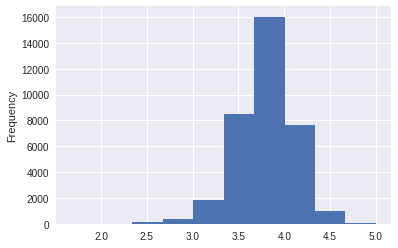

In [27]:
beer_reviews_df.feel.plot('hist')

## Reload csv to avoid processing again

In [5]:
data_dir = os.path.join(os.path.curdir, "data")

style_data = pd.read_csv(os.path.join(data_dir,'initial_data.csv'), index_col=0)
review_data = pd.read_csv(os.path.join(data_dir, 'beer_review_data.csv'), index_col=0)

style_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35753 entries, Fat Tire Amber Ale-New Belgium Brewing to Grewit Barrel-aged Old World Ale-Propolis Brewing
Data columns (total 6 columns):
link       35753 non-null object
brewery    35753 non-null object
abv        35753 non-null float64
score      35753 non-null float64
ratings    35753 non-null int64
style      35753 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 1.9+ MB


In [6]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35748 entries,  Illustrated Man Dark Sour with Berries-Independence Brewing Co to ﻿Boji Blue Pale Ale-Okoboji Brewing Company
Data columns (total 10 columns):
ba_score    34181 non-null float64
ratings     35748 non-null object
reviews     35748 non-null object
perc_dev    35748 non-null object
wants       35748 non-null object
gots        35748 non-null object
look        35625 non-null float64
smell       35625 non-null float64
taste       35625 non-null float64
feel        35625 non-null float64
dtypes: float64(5), object(5)
memory usage: 3.0+ MB


In [12]:
combined_data = review_data.merge(style_data, how='inner', left_index=True, right_index=True)

In [13]:
combined_data.head()

ba_score ratings_x  \
 Illustrated Man Dark Sour with Berries-Indepen...      84.0        13   
!!!PA Simcoe Mosaic-To Øl                               82.0        13   
"633" American Pale Ale-Boothbay Craft Brewery ...      84.0        24   
"Admiral" Stash-Milwaukee Brewing Company               85.0        50   
"Keeper!"-The Phoenix Ale Brewery                       83.0        24   

                                                   reviews perc_dev wants  \
 Illustrated Man Dark Sour with Berries-Indepen...       1   11.58%     0   
!!!PA Simcoe Mosaic-To Øl                                7   27.83%     0   
"633" American Pale Ale-Boothbay Craft Brewery ...       6   13.46%     0   
"Admiral" Stash-Milwaukee Brewing Company                9   14.47%     2   
"Keeper!"-The Phoenix Ale Brewery                        2   13.74%     0   

                                                   gots      look     smell  \
 Illustrated Man Dark Sour with Berries-Indepen...    4  3.846154  3.769231   
!!!PA Simcoe Mosaic-To Øl                             1  3.500000  3.461538   
"633" American Pale Ale-Boothbay Craft Brewery ...    3  3.602941  3.529412   
"Admiral" Stash-Milwaukee Brewing Company            10  3.772727  3.750000   
"Keeper!"-The Phoenix Ale Brewery                     3  3.583333  3.416667   

                                                       taste      feel  \
 Illustrated Man Dark Sour with Berries-Indepen...  3.769231  3.846154   
!!!PA Simcoe Mosaic-To Øl                           3.423077  3.519231   
"633" American Pale Ale-Boothbay Craft Brewery ...  3.411765  3.500000   
"Admiral" Stash-Milwaukee Brewing Company           3.840909  3.795455   
"Keeper!"-The Phoenix Ale Brewery                   3.472222  3.527778   

                                                                           link  \
 Illustrated Man Dark Sour with Berries-Indepen...  /beer/profile/10284/271687/   
!!!PA Simcoe Mosaic-To Øl                           /beer/profile/24299/255424/   
"633" American Pale Ale-Boothbay Craft Brewery ...   /beer/profile/29390/82909/   
"Admiral" Stash-Milwaukee Brewing Company            /beer/profile/18680/79709/   
"Keeper!"-The Phoenix Ale Brewery                   /beer/profile/26382/106601/   

                                                                                     brewery  \
 Illustrated Man Dark Sour with Berries-Indepen...                   Independence Brewing Co   
!!!PA Simcoe Mosaic-To Øl                                                              To Øl   
"633" American Pale Ale-Boothbay Craft Brewery ...  Boothbay Craft Brewery  Watershed Tavern   
"Admiral" Stash-Milwaukee Brewing Company                          Milwaukee Brewing Company   
"Keeper!"-The Phoenix Ale Brewery                                    The Phoenix Ale Brewery   

                                                      abv  score  ratings_y  \
 Illustrated Man Dark Sour with Berries-Indepen...   5.50   3.80         13   
!!!PA Simcoe Mosaic-To Øl                           13.00   3.27         13   
"633" American Pale Ale-Boothbay Craft Brewery ...   6.33   3.78         23   
"Admiral" Stash-Milwaukee Brewing Company            7.00   3.87         50   
"Keeper!"-The Phoenix Ale Brewery                    6.30   3.64         24   

                                                                        style  
 Illustrated Man Dark Sour with Berries-Indepen...            AmericanWildAle  
!!!PA Simcoe Mosaic-To Øl                           AmericanDoubleImperialIPA  
"633" American Pale Ale-Boothbay Craft Brewery ...            AmericanPaleAle  
"Admiral" Stash-Milwaukee Brewing Company                        BalticPorter  
"Keeper!"-The Phoenix Ale Brewery                                BieredeGarde

In [14]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35750 entries,  Illustrated Man Dark Sour with Berries-Independence Brewing Co to ﻿Boji Blue Pale Ale-Okoboji Brewing Company
Data columns (total 16 columns):
ba_score     34183 non-null float64
ratings_x    35750 non-null object
reviews      35750 non-null object
perc_dev     35750 non-null object
wants        35750 non-null object
gots         35750 non-null object
look         35627 non-null float64
smell        35627 non-null float64
taste        35627 non-null float64
feel         35627 non-null float64
link         35750 non-null object
brewery      35750 non-null object
abv          35750 non-null float64
score        35750 non-null float64
ratings_y    35750 non-null int64
style        35750 non-null object
dtypes: float64(7), int64(1), object(8)
memory usage: 4.6+ MB


In [18]:
combined_data.drop('ratings_y', inplace=True, axis=1)

In [20]:
combined_data.rename(columns={'ratings_x' : 'ratings'}, inplace=True)

In [21]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35750 entries,  Illustrated Man Dark Sour with Berries-Independence Brewing Co to ﻿Boji Blue Pale Ale-Okoboji Brewing Company
Data columns (total 15 columns):
ba_score    34183 non-null float64
ratings     35750 non-null object
reviews     35750 non-null object
perc_dev    35750 non-null object
wants       35750 non-null object
gots        35750 non-null object
look        35627 non-null float64
smell       35627 non-null float64
taste       35627 non-null float64
feel        35627 non-null float64
link        35750 non-null object
brewery     35750 non-null object
abv         35750 non-null float64
score       35750 non-null float64
style       35750 non-null object
dtypes: float64(7), object(8)
memory usage: 4.4+ MB


In [23]:
combined_data['perc_dev_1'] = combined_data['perc_dev'].str.replace("%", "")

In [25]:
combined_data['perc_dev'] = combined_data.perc_dev_1.map(lambda x: float(x))

In [27]:
combined_data.drop('perc_dev_1', inplace=True, axis=1)

In [34]:
combined_data['reviews'] = combined_data.reviews.str.replace(",", "")
combined_data['ratings'] = combined_data.ratings.str.replace(",", "")


AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [35]:
combined_data['wants'] = combined_data.wants.str.replace(",", "")
combined_data['gots'] = combined_data.gots.str.replace(",", "")

In [31]:
combined_data['reviews'] = combined_data.reviews.map(lambda x: int(x))
combined_data['ratings'] = combined_data.ratings.map(lambda x: int(x))


In [36]:
combined_data['wants'] = combined_data.wants.map(lambda x: int(x))
combined_data['gots'] = combined_data.gots.map(lambda x: int(x))

In [43]:
cleaned_data = combined_data.loc[combined_data.ba_score.notnull(), :]

In [44]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34183 entries,  Illustrated Man Dark Sour with Berries-Independence Brewing Co to ﻿Boji Blue Pale Ale-Okoboji Brewing Company
Data columns (total 15 columns):
ba_score    34183 non-null float64
ratings     34183 non-null int64
reviews     34183 non-null int64
perc_dev    34183 non-null float64
wants       34183 non-null int64
gots        34183 non-null int64
look        34134 non-null float64
smell       34134 non-null float64
taste       34134 non-null float64
feel        34134 non-null float64
link        34183 non-null object
brewery     34183 non-null object
abv         34183 non-null float64
score       34183 non-null float64
style       34183 non-null object
dtypes: float64(8), int64(4), object(3)
memory usage: 4.2+ MB


In [46]:
cleaned_data.to_csv(os.path.join("data", "cleaned_beer_data.csv"))